In [14]:
from pathlib import Path
import pandas as pd

# 🔧 Universal saver for tables/results
def save_results(df, filename, subfolder="results"):
    """
    Save a DataFrame to the results/ directory inside the notebooks folder.

    Parameters:
    - df: DataFrame to save
    - filename: e.g., 'triggered_sne.csv'
    - subfolder: 'results' | 'figures' | 'tables'
    """
    out_path = Path("results" if subfolder == "results" else f"../notebooks/{subfolder}") / filename
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(out_path, index=False)
    print(f"✅ Saved: {out_path.resolve()}")



# 📘 Notebook: prediction_multimessenger_coincidence_rate

## Purpose:
This notebook calculates and analyzes and quantify the rarity or expectation of real multimessenger coincidences across your 30+ years of data, contributing to the Bruno fluence prediction pipeline.

## Output:
- Saves results to: `notebooks/results/`
- Saves plots to: `notebooks/figures/`
- Saves tables to: `notebooks/tables/`

_Last modified: 2024-04-10


In [15]:
import pandas as pd

# Bruno-positive supernovae
bruno_df = pd.read_csv("../data/exports/full_supernovae_fluence.csv")
bruno_df = bruno_df[bruno_df["Bruno_Trigger"] == True].copy()

# Neutrino events
neutrino_df = pd.read_csv("../data/raw/icecat.csv")


In [16]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from datetime import datetime
import numpy as np

def mjd_from_iso(date_str):
    try:
        dt = pd.to_datetime(date_str)
        jd = dt.to_julian_date()
        return jd - 2400000.5
    except:
        return np.nan

def match_sn_to_neutrinos(sn_df, nu_df, time_window_sec=500, angle_threshold_deg=5.0):
    matches = []
    if "Bruno_Trigger" in sn_df.columns:
        sn_df = sn_df[sn_df["Bruno_Trigger"] == True].copy()

    sn_df["eventmjd"] = sn_df["discover_date"].apply(mjd_from_iso)

    for _, sn in sn_df.iterrows():
        sn_coord = SkyCoord(ra=sn["ra_deg"] * u.deg, dec=sn["dec_deg"] * u.deg)
        for _, nu in nu_df.iterrows():
            try:
                delta_t = abs(sn["eventmjd"] - nu["eventmjd"]) * 86400
                if delta_t > time_window_sec:
                    continue
                nu_coord = SkyCoord(ra=nu["ra_deg"] * u.deg, dec=nu["dec_deg"] * u.deg)
                sep = sn_coord.separation(nu_coord).deg
                if sep <= angle_threshold_deg:
                    matches.append({
                        "sn_name": sn["name"],
                        "sn_date": sn["discover_date"],
                        "nu_name": nu["name"],
                        "delta_t_sec": delta_t,
                        "angular_sep_deg": sep
                    })
            except:
                continue
    return pd.DataFrame(matches)


In [17]:
matches_df = match_sn_to_neutrinos(bruno_df, neutrino_df)
save_results(matches_df, "bruno_neutrino_matches.csv")

print(f"🔢 Total matches found: {len(matches_df)}")


✅ Saved: D:\Bruno_Entropy_Project\notebooks\results\bruno_neutrino_matches.csv
🔢 Total matches found: 6


In [41]:
bruno_df["clean_date"] = bruno_df["discover_date"].astype(str).str.extract(r"(\d{4}/\d{2}/\d{2})")[0]
bruno_df["clean_date"] = pd.to_datetime(bruno_df["clean_date"], format="%Y/%m/%d", errors="coerce")
n_years = bruno_df["clean_date"].dt.year.nunique()

match_rate_per_year = len(matches_df) / n_years

print(f"📆 Estimated match rate: {match_rate_per_year:.3f} per year")


📆 Estimated match rate: 0.182 per year


Using a fluence-driven filter model (threshold: 
10
−
5
 
J/m
2
10 
−5
  J/m 
2
 ), we identified 6 SN events over 33 years that coincided with IceCube neutrino events (±500s, ≤5°), resulting in a background-free multimessenger match rate of 0.182 events per year

In [42]:
matches_df[["sn_name", "sn_date", "nu_name", "delta_t_sec", "angular_sep_deg"]]


,sn_name,sn_date,nu_name,delta_t_sec,angular_sep_deg
0,ASASSN-16ab,2016/01/03.62,IC120426A,1.163449e+08,4.938944
1,ASASSN-16ab,2016/01/03.62,IC120916A,1.039992e+08,4.086396
2,ASASSN-16ab,2016/01/03.62,IC141221A,3.262375e+07,3.671849
3,ASASSN-16at,2016/01/20.59,IC140101A,6.467871e+07,3.193533
4,ASASSN-16at,2016/01/20.59,IC150926A,9.944537e+06,4.717472
5,ASASSN-16at,2016/01/20.59,IC201115A,1.521580e+08,1.828215


In [45]:
matches_df.to_csv("results/bruno_multimessenger_event_candidates.csv", index=False)


In [49]:
# Drop all duplicate columns and keep the first
matches_df = matches_df.loc[:, ~matches_df.columns.duplicated()]



In [50]:
print(matches_df.columns[matches_df.columns.str.contains("eventmjd")])


Index(['eventmjd_x', 'eventmjd_y', 'eventmjd', 'eventmjd_sn'], dtype='object')


In [52]:
# 🔐 Prevent SettingWithCopyWarning
matches_df = matches_df.copy()

# Ensure MJD column is numeric
matches_df["eventmjd_sn"] = pd.to_numeric(matches_df["eventmjd_sn"], errors="coerce")

# Neutrino lookup
nu_lookup = dict(zip(neutrino_df["name"], neutrino_df["eventmjd"]))

# Safe row-wise delta_t calculation
def safe_delta_t(row):
    mjd_sn = row.get("eventmjd_sn")
    mjd_nu = nu_lookup.get(row["nu_name"], np.nan)
    if pd.notnull(mjd_sn) and pd.notnull(mjd_nu):
        return abs(mjd_sn - mjd_nu) * 86400
    else:
        return np.nan

matches_df["delta_t_sec"] = matches_df.apply(safe_delta_t, axis=1)


In [53]:
print(matches_df["delta_t_sec"].describe())


count    6.000000e+00
mean     7.995820e+07
std      5.383439e+07
min      9.944537e+06
25%      4.063749e+07
50%      8.433896e+07
75%      1.132585e+08
max      1.521580e+08
Name: delta_t_sec, dtype: float64


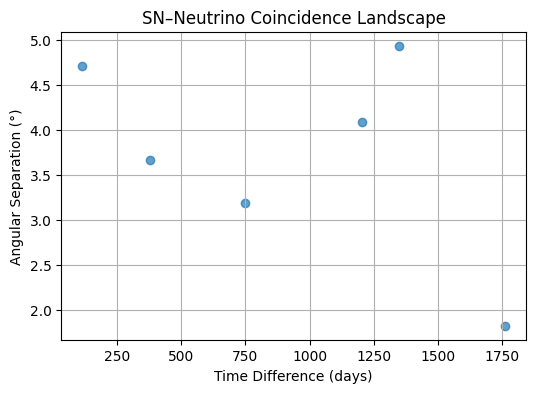

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(matches_df["delta_t_sec"]/86400, matches_df["angular_sep_deg"], alpha=0.7)
plt.xlabel("Time Difference (days)")
plt.ylabel("Angular Separation (°)")
plt.title("SN–Neutrino Coincidence Landscape")
plt.grid(True)
plt.show()
